# demo_run.ipynb 示例

本笔记演示 CellType-GP 的完整流程：载入预处理的空间转录组数据、运行解卷积模型，并与 Xenium 真值打分进行对比评估。

## 1. 环境与路径

如果仓库位于其他位置，请先修改基础路径。`DATA` 目录需包含 `spot_data_full.npz` 以及对应的真值 CSV 文件。

In [18]:
from pathlib import Path
import pandas as pd

project_root = Path('/home/vs_theg/ST_program/CellType_GP')
package_dir = project_root / 'CellType-GP'
data_dir = project_root / 'DATA'
output_dir = data_dir / 'notebook_outputs'
output_dir.mkdir(exist_ok=True, parents=True)

print(f'Project root: {project_root}')
print(f'Package dir : {package_dir}')
print(f'Data dir    : {data_dir}')

Project root: /home/vs_theg/ST_program/CellType_GP
Package dir : /home/vs_theg/ST_program/CellType_GP/CellType-GP
Data dir    : /home/vs_theg/ST_program/CellType_GP/DATA


## 2. 查看输入矩阵

加载 NPZ 数据包，其中存放 Gene Program 得分 (`visium_score`) 与细胞类型比例 (`spot_cluster_fraction_matrix`)。

In [19]:
import numpy as np
spot_bundle = np.load(data_dir / 'spot_data_full.npz', allow_pickle=True)

Y = spot_bundle['visium_score']            # shape (programs, spots)
X = spot_bundle['spot_cluster_fraction_matrix']  # shape (spots, cell types)
coords = spot_bundle['coords']
spot_names = spot_bundle['spot_names']
celltype_names = spot_bundle['celltype_names']
program_names = spot_bundle['program_names']

print('visium_score shape:', Y.shape)
print('spot_cluster_fraction_matrix shape:', X.shape)
print('coords shape:', coords.shape)
print('First 5 spot IDs:', spot_names[:5])

visium_score shape: (17, 3953)
spot_cluster_fraction_matrix shape: (3953, 7)
coords shape: (3953, 2)
First 5 spot IDs: ['AACACGTGCATCGCAC-1' 'AACACTTGGCAAGGAA-1' 'AACAGGAAGAGCATAG-1'
 'AACAGGATTCATAGTT-1' 'AACAGGTTATTGCACC-1']


## 3. 运行模型

依次运行三种解卷积方案，分别输出向量化残差 (`pred_vectorized.csv`)、留一法残差 (`pred_delta.csv`) 以及神经网络模型 (`train_nn.csv`) 的预测结果。

### 3.1 向量化残差模型

In [20]:
from celltype_gp_models import run_model

pred_vectorized_csv = output_dir / 'pred_vectorized.csv'
pred_vectorized_df = run_model(
    npz_path=str(data_dir / 'spot_data_full.npz'),
    method='vectorized',
    save_path=str(pred_vectorized_csv)
)

pred_vectorized_df.head()

/home/vs_theg/ST_program/CellType_GP/CellType-GP/celltype_gp_models.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
/home/vs_theg/ST_program/CellType_GP/CellType-GP/celltype_gp_models.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/pred_vectorized.csv，形状 (3953, 119)


,B_Cells+Stromal_score_norm,B_Cells+Prolif_Invasive_Tumor_score_norm,B_Cells+Perivascular_Like_score_norm,B_Cells+Myoepi_KRT15_score_norm,B_Cells+Myoepi_ACTA2_score_norm,B_Cells+Mast_Cells_score_norm,B_Cells+Macrophages_2_score_norm,B_Cells+Macrophages_1_score_norm,B_Cells+LAMP3_DCs_score_norm,B_Cells+IRF7_DCs_score_norm,...,T_cells+Macrophages_1_score_norm,T_cells+LAMP3_DCs_score_norm,T_cells+IRF7_DCs_score_norm,T_cells+Invasive_Tumor_score_norm,T_cells+Endothelial_score_norm,T_cells+DCIS_2_score_norm,T_cells+DCIS_1_score_norm,T_cells+CD8_T_Cells_score_norm,T_cells+CD4_T_Cells_score_norm,T_cells+B_Cells_score_norm
AACACGTGCATCGCAC-1,0.608259,0.594964,0.425781,0.241482,0.259212,0.410460,0.529700,0.248786,0.295000,0.411109,...,0.211524,0.252660,0.346832,0.347111,0.365483,0.761549,0.423501,0.325245,0.146678,0.284254
AACACTTGGCAAGGAA-1,0.407469,0.745524,0.507597,0.481887,0.721743,0.154109,0.368708,0.415759,0.403420,0.261632,...,0.446940,0.440893,0.313459,0.255665,0.487773,0.782453,0.668020,0.294494,0.114486,0.353633
AACAGGAAGAGCATAG-1,0.410160,0.793071,0.553862,0.411572,0.499070,0.422775,0.580936,0.451137,0.651881,0.291052,...,0.438112,0.629698,0.275675,0.295044,0.346922,0.522558,0.583990,0.449154,0.274783,0.354534
AACAGGATTCATAGTT-1,0.638267,0.583823,0.295400,0.214613,0.205515,0.214482,0.410980,0.121615,0.254781,0.081998,...,0.154761,0.294904,0.136812,0.546164,0.469286,0.269009,0.404639,-0.026268,0.194792,0.141035
AACAGGTTATTGCACC-1,0.632102,0.615964,0.379721,0.340715,0.347080,0.258673,0.665320,0.409378,0.558123,0.383642,...,0.396353,0.535940,0.368265,0.282369,0.403522,0.308892,0.508636,0.222876,0.078068,0.676972


### 3.2 留一法残差模型

In [21]:
pred_delta_csv = output_dir / 'pred_delta.csv'
pred_delta_df = run_model(
    npz_path=str(data_dir / 'spot_data_full.npz'),
    method='delta',
    save_path=str(pred_delta_csv)
)

pred_delta_df.head()

✅ 已保存结果到 /home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/pred_delta.csv，形状 (3953, 119)


,B_Cells+Stromal_score_norm,B_Cells+Prolif_Invasive_Tumor_score_norm,B_Cells+Perivascular_Like_score_norm,B_Cells+Myoepi_KRT15_score_norm,B_Cells+Myoepi_ACTA2_score_norm,B_Cells+Mast_Cells_score_norm,B_Cells+Macrophages_2_score_norm,B_Cells+Macrophages_1_score_norm,B_Cells+LAMP3_DCs_score_norm,B_Cells+IRF7_DCs_score_norm,...,T_cells+Macrophages_1_score_norm,T_cells+LAMP3_DCs_score_norm,T_cells+IRF7_DCs_score_norm,T_cells+Invasive_Tumor_score_norm,T_cells+Endothelial_score_norm,T_cells+DCIS_2_score_norm,T_cells+DCIS_1_score_norm,T_cells+CD8_T_Cells_score_norm,T_cells+CD4_T_Cells_score_norm,T_cells+B_Cells_score_norm
AACACGTGCATCGCAC-1,0.000028,-0.000035,0.000021,-0.000007,0.000003,0.000036,0.000041,0.000043,0.000036,0.000087,...,-0.000022,-0.000030,-0.000033,5.006790e-06,-1.227856e-05,1.817942e-06,2.890825e-06,-0.000047,-0.000048,-0.000026
AACACTTGGCAAGGAA-1,-0.000024,0.000029,-0.000018,0.000006,-0.000003,-0.000030,-0.000035,-0.000036,-0.000030,-0.000074,...,0.000013,0.000018,0.000020,-3.069639e-06,7.510185e-06,-1.102686e-06,-1.788139e-06,0.000029,0.000030,0.000016
AACAGGAAGAGCATAG-1,-0.000012,0.000015,-0.000009,0.000003,-0.000002,-0.000015,-0.000018,-0.000019,-0.000016,-0.000038,...,-0.000001,-0.000002,-0.000002,3.278255e-07,-7.748604e-07,1.192093e-07,1.490116e-07,-0.000003,-0.000003,-0.000002
AACAGGATTCATAGTT-1,-0.000024,0.000029,-0.000018,0.000006,-0.000003,-0.000030,-0.000035,-0.000037,-0.000030,-0.000074,...,0.000020,0.000027,0.000031,-4.649162e-06,1.135468e-05,-1.668930e-06,-2.682209e-06,0.000043,0.000045,0.000024
AACAGGTTATTGCACC-1,-0.000013,0.000016,-0.000010,0.000003,-0.000002,-0.000017,-0.000019,-0.000020,-0.000017,-0.000041,...,-0.000005,-0.000007,-0.000008,1.236796e-06,-3.039837e-06,4.470348e-07,6.854534e-07,-0.000012,-0.000012,-0.000007


### 3.3 神经网络学习模型

In [22]:
import subprocess

neural_output = output_dir / 'train_nn.csv'
script_path = package_dir / 'celltype_gp_deconvolution.py'
result = subprocess.run(['python', str(script_path)], check=False)
if result.returncode != 0:
    print('神经网络脚本执行失败，返回码:', result.returncode)
else:
    train_path = data_dir / 'train1500_result(wide).csv'
    if train_path.exists():
        df_train = pd.read_csv(train_path, index_col=0)
        df_train.to_csv(neural_output)
        print('神经网络结果已复制到:', neural_output)
    else:
        print('未找到神经网络输出文件:', train_path)

neural_output

Y (shape: torch.Size([17, 3953])):
tensor([[0.7772, 0.4365, 0.6146, 0.7400, 0.8269],
        [0.4100, 0.7059, 0.5777, 0.4811, 0.4062],
        [0.4438, 0.5858, 0.5757, 0.4009, 0.4026],
        [0.1755, 0.5340, 0.3346, 0.2354, 0.2671],
        [0.1882, 0.7878, 0.4192, 0.2440, 0.2694]])

X (shape: torch.Size([3953, 7])):
tensor([[0.0714, 0.0000, 0.0000, 0.0000, 0.0714],
        [0.0000, 0.1064, 0.2128, 0.0000, 0.1702],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2222, 0.0000, 0.1111],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0455]])

coords (shape: (3953, 2)):
[[13355 16640]
 [ 8845 12067]
 [14716 15518]
 [11404 12365]
 [ 7452  9059]]
Epoch 0, Loss=27.5169, Recon=0.1181
Epoch 100, Loss=22.8417, Recon=0.0942
Epoch 200, Loss=18.4040, Recon=0.0858
Epoch 300, Loss=14.3328, Recon=0.0875
Epoch 400, Loss=10.7468, Recon=0.0956
Epoch 500, Loss=7.7097, Recon=0.1075
Epoch 600, Loss=5.2401, Recon=0.1211
Epoch 700, Loss=3.3262, Recon=0.1345
Epoch 800, Loss=1.9276, R

PosixPath('/home/vs_theg/ST_program/CellType_GP/DATA/notebook_outputs/train_nn.csv')

## 4. 对照真值打分

使用 `evaluation.evaluate_deconvolution_enhanced` 同时评估三种解卷积方案：向量化残差、留一法残差以及神经网络模型。下表展示每种方法的平均 PearsonR 与 F1。

In [23]:
from evaluation import evaluate_deconvolution_enhanced

truth_wide = pd.read_csv(data_dir / 'truth_output' / 'truth_result(wide).csv', index_col=0)
metrics_dir = output_dir / 'metrics'
metrics_dir.mkdir(exist_ok=True, parents=True)

method_specs = {
    '向量化残差模型': {'path': output_dir / 'pred_vectorized.csv', 'slug': 'vectorized'},
    '留一法残差模型': {'path': output_dir / 'pred_delta.csv', 'slug': 'delta'},
    '神经网络模型': {'path': output_dir / 'train_nn.csv', 'slug': 'neural'},
}

metrics_results = {}
pred_tables = {}
summary_rows = []

for label, spec in method_specs.items():
    csv_path = spec['path']
    slug = spec['slug']
    pred_table = pd.read_csv(csv_path, index_col=0)
    pred_tables[label] = pred_table
    metrics_df = evaluate_deconvolution_enhanced(
        truth_wide=truth_wide,
        pred_wide=pred_table,
        verbose=False,
        compute_prob_metrics=False
    )
    metrics_results[label] = metrics_df
    metrics_file = metrics_dir / f"{slug}_metrics.csv"
    metrics_df.to_csv(metrics_file, index=False)
    summary_rows.append({
        '方法': label,
        '平均 PearsonR': metrics_df['PearsonR'].mean(skipna=True),
        '平均 F1': metrics_df['F1'].mean(skipna=True),
        '指标文件': metrics_file.name
    })

summary_df = pd.DataFrame(summary_rows)
summary_path = metrics_dir / 'metrics_summary.csv'
summary_df.to_csv(summary_path, index=False)
summary_df

,方法,平均 PearsonR,平均 F1
0,向量化残差模型,0.178719,0.621291
1,留一法残差模型,0.052457,0.551182
2,神经网络模型,0.008270,0.474270


In [32]:
metrics_df

,feature,PearsonR,SpearmanR,RMSE,MAE,N_pairs,coverage,TP,FP,TN,FN,Precision,Recall,F1,AUROC,AUPR
0,Stromal+Stromal_score_norm,0.107976,0.095542,0.555643,0.542271,3675,0.929674,2006,151,127,1669,0.929995,0.545850,0.687929,NaN,NaN
1,DCIS+DCIS_1_score_norm,0.107793,0.096766,0.606912,0.593686,800,0.202378,438,1570,1583,362,0.218127,0.547500,0.311966,NaN,NaN
2,Invasive_Tumor+Prolif_Invasive_Tumor_score_norm,0.099669,0.092661,0.683014,0.676516,1298,0.328358,716,1299,1356,582,0.355335,0.551618,0.432237,NaN,NaN
3,DCIS+DCIS_2_score_norm,0.073336,0.034228,0.451731,0.442105,800,0.202378,451,1545,1608,349,0.225952,0.563750,0.322604,NaN,NaN
4,T_cells+Macrophages_1_score_norm,0.070881,0.077718,0.136382,0.112036,1582,0.400202,793,1180,1191,789,0.401926,0.501264,0.446132,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,DCIS+Macrophages_2_score_norm,-0.038967,-0.020323,0.056398,0.041887,800,0.202378,424,1581,1572,376,0.211471,0.530000,0.302317,NaN,NaN
115,B_Cells+Macrophages_1_score_norm,-0.038972,-0.043053,0.143585,0.122986,1180,0.298507,595,1333,1440,585,0.308610,0.504237,0.382883,NaN,NaN
116,B_Cells+Perivascular_Like_score_norm,-0.051002,-0.064697,0.129895,0.115970,1180,0.298507,582,1406,1367,598,0.292757,0.493220,0.367424,NaN,NaN
117,T_cells+CD8_T_Cells_score_norm,-0.052377,-0.044667,0.502206,0.489235,1582,0.400202,762,1166,1205,820,0.395228,0.481669,0.434188,NaN,NaN


## 5. 对比三种方法的相关性分布

通过直方图对比三种方法与真值之间的 Pearson 相关系数分布，并在图标题中标注对应的解卷积方法。

TypeError: evaluate_deconvolution_enhanced() got an unexpected keyword argument 'ax'

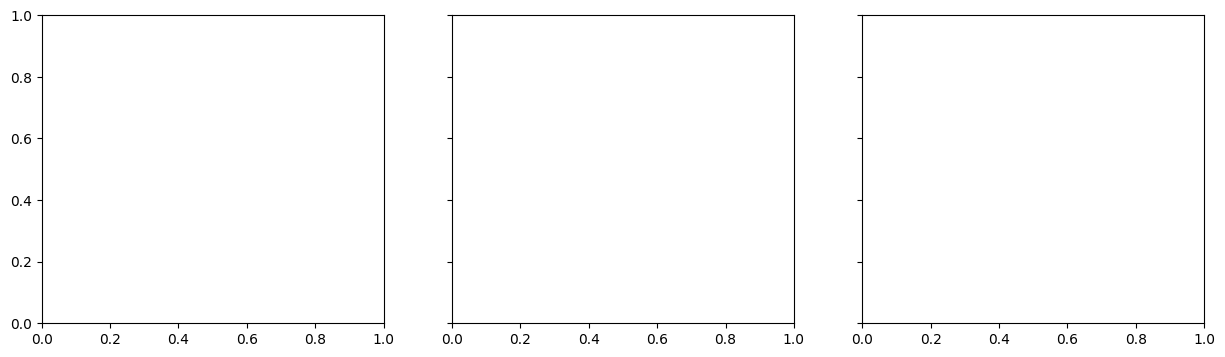

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

for ax, (label, pred_table) in zip(axes, pred_tables.items()):
    evaluate_deconvolution_enhanced(
        truth_wide=truth_wide,
        pred_wide=pred_table,
        verbose=True,
        compute_prob_metrics=False,
        ax=ax,
        plot_title=f'{label} vs Truth'
    )

fig.suptitle('反卷积方法与真值的 PearsonR 分布对比', fontsize=14)
plt.tight_layout()
plt.show()

## 6. 可选：重新计算基因程序得分

若需重新生成打分矩阵，可运行预处理脚本。该步骤依赖 Scanpy、Squidpy 及图形后端；使用前请按需取消注释。

In [ ]:
# from preprocessing import score_gene_programs  # heavy Scanpy dependencies
# import scanpy as sc
#
# adata_x = sc.read(data_dir / 'xdata.h5')
#
# # gene_sets_to_score is defined inside preprocessing.py; import if needed
# from preprocessing import gene_sets_to_score
# score_gene_programs(adata_x, gene_sets_to_score, platform='xenium', output_dir=data_dir / 'xenium_scores')
# adata_x.write(data_dir / 'xdata_processed.h5')

## 7. 可选：神经网络解卷积基线

脚本 `celltype_gp_deconvolution.py` 提供基于拉普拉斯正则的替代模型，可独立运行以训练并保存 `Y_tps_result.csv`。

```bash
python CellType-GP/celltype_gp_deconvolution.py
```